# CNC Mill Tool Wear Detection
### _Data exploration and modeling for the [CNC Mill Tool Wear Dataset](https://www.kaggle.com/datasets/shasun/tool-wear-detection-in-cnc-mill/)._
_This data was extracted using the Rockwell Cloud Collector Agent Elastic software from a CNC milling machine in the System-level Manufacturing and Automation Research Testbed (SMART) at the University of Michigan. Uploaded by [Sharon Sun]()._


### Table of Contents
1. [Introduction](#introduction)
    1. [Hypothesis](#hypothesis)
    2. [Acknowledgement](#acknowledgement)
2. [Data Description](#data-description)
3. [Preprocessing](#preprocessing)
4. [Basic Visualization](#basic-visualization)
5. [Data Analysis](#data-analysis)
    1. [Modeling with Time Series Entries](#modeling-with-time-series-entries)
    2. [Modeling with Frequency Data (Toy Example)](#modeling-with-freqency-data-toy-example)


## Introduction
The CNC (Computer Numerical Control) machine is a type of computer-controlled manufacturing tool analogous to a super-smart robot that can cut, shape, and create objects with precision. 
Instead of being operated manually, CNC machines follow instructions from a computer program. 
These instructions tell the machine how to move its tools to carve out or assemble parts from raw materials like metal, wood, or plastic. 
CNC machines are used in industries like aerospace, automotive, and electronics to make everything from airplane parts to smartphone components.

One specific type of CNC machine is the CNC mill (shown in figures below). 
In CNC milling, a solid block (called the workpiece) is clamped into a vise on the machining table.
The machine uses a spinning tool (like a drill) attached to a spindle to cut away material create a desired shape. 
Thanks to the precision of numerical control and the multiple moving axes, CNC mills are especially good at creating complex 3D shapes and intricate designs.

|[<img src="./haas-cm1.png" alt="Link to the product page." height="300"/>](https://www.haascnc.com/machines/vertical-mills/compact-mills/models/cm-1.html)|[<img src="./haas-cm1-in-action.png" alt="Link to the YouTube demo." height="300"/>](https://www.youtube.com/watch?v=vj1goyp9Spg)|
|:-:|:-:|
|A Haas CM-1 compact mill. |The CM-1 mill in action with the TRT70 rotary table that orients the workpiece in different directions. |

The cutting tools on the CNC mill experience wear over time due to friction, heat, and stress during operations. 
On a production line where workpieces are milled in batch, being able to detect tool wear ensures product quality, cost efficiency, and safety. Therefore, in this project, I aim to:
- Explore a dataset obtained from a series of CNC milling experiments
- Investigate the possibily of modeling and predicting tool wear through the machine status data.

<div class="alert">

### Hypothesis
I hypothesize that using the CNC milling machine measurements, we can predict tool wear without visual inspection.

</div>


### Acknowledgement

This project was inspired by the "<a ref="https://www.kaggle.com/code/koheimuramatsu/cnc-milling-machine-tool-wear-detection"> CNC milling machine - Tool Wear Detection</a>" Python project by <a ref="https://www.kaggle.com/koheimuramatsu">Kohei Muramatsu</a>.

I selected this dataset because the previously chosen Anxiety Attack dataset was no longer available. This CNC milling dataset comes from an engineering background - which I have the knowledge of. It offers me a good opportunity practice data exploration R and knowledge exchange with audiences from a different background.



## Data Description

The series of experiments was run on 2" x 2" x 1.5" wax blocks in a 3-axis CNC milling machine in the System-level Manufacturing and Automation Research Testbed (SMART) at the University of Michigan. Machining data was collected from a CNC machine for variations of tool condition, feed rate, and clamping pressure. Each experiment produced a finished wax part with an "S" shape carved into the top face, as shown below.

|<img src="./tool-wear-detection-in-cnc-mill/test_artifact.jpg" height="300"/>|
|:-:|
| The finished wax part with an "S" shape - S for smart manufacturing. |

The author of the dataset provided a detailed description of the available data (see [`README.txt`](./tool-wear-detection-in-cnc-mill/README.txt)), cited and formatted below:

<blockquote>

General data from a total of 18 different experiments are given in train.csv and includes:

**Inputs (features)**
- `No`: experiment number
- `material`: wax
- `feed_rate`: relative velocity of the cutting tool along the workpiece (mm/s)
- `clamp_pressure`: pressure used to hold the workpiece in the vise (bar)

**Outputs (predictions)**
- `tool_condition`: label for unworn and worn tools
- `machining_completed`: indicator for if machining was completed without the workpiece moving out of the pneumatic vise
- `passed_visual_inspection`: indicator for if the workpiece passed visual inspection, only available for experiments where machining was completed


Time series data was collected from 18 experiments with a sampling rate of 100 ms and are separately reported in files `experiment_01.csv` to `experiment_18.csv`. Each file has measurements from the 4 motors in the CNC (X, Y, Z axes and spindle; denoted as `X1`, `Y1`, `Z1`, and `S1`, respectively). The features available in the machining datasets are:

- X, Y, Z axes measurements:
    - `*_ActualPosition`: actual position of part in *-direction (mm)
    - `*_ActualVelocity`: actual *-direction velocity of part (mm/s)
    - `*_ActualAcceleration`: actual *-direction acceleration of part (mm/s/s)
    - `*_CommandPosition`: reference *-direction position of part (mm)
    - `*_CommandVelocity`: reference *-direction velocity of part (mm/s)
    - `*_CommandAcceleration`: reference *-direction acceleration of part (mm/s/s)
    - `*_CurrentFeedback`: *-direction current (A)
    - `*_DCBusVoltage`: *-direction voltage (V)
    - `*_OutputCurrent`: *-direction current (A)
    - `*_OutputVoltage`: *-direction voltage (V)
    - `*_OutputPower`: *-direction power (kW)
- Spindle measurements:
    - `S1_ActualPosition`: actual position of spindle (mm)
    - `S1_ActualVelocity`: actual velocity of spindle (mm/s)
    - `S1_ActualAcceleration`: actual acceleration of spindle (mm/s/s)
    - `S1_CommandPosition`: reference position of spindle (mm)
    - `S1_CommandVelocity`: reference velocity of spindle (mm/s)
    - `S1_CommandAcceleration`: reference acceleration of spindle (mm/s/s)
    - `S1_CurrentFeedback`: current (A)
    - `S1_DCBusVoltage`: voltage (V)
    - `S1_OutputCurrent`: current (A)
    - `S1_OutputVoltage`: voltage (V)
    - `S1_OutputPower`: current (A)
    - `S1_SystemInertia`: torque inertia (kg*m^2)
- Program information:
    - `M1_CURRENT_PROGRAM_NUMBER`: number the program is listed under on the CNC
    - `M1_sequence_number`: line of G-code being executed
    - `M1_CURRENT_FEEDRATE`: instantaneous feed rate of spindle
    - `Machining_Process`: the current machining stage being performed. Includes preparation, tracing up and down the "S" curve involving different layers, and repositioning of the spindle as it moves through the air to a certain starting point

</blockquote>


## Preprocessing

First, we load the required libraries and data:

In [3]:
library(tidyverse)

# Load general results
exp_result <- read.csv("tool-wear-detection-in-cnc-mill/train.csv")
head(exp_result)

# Load experiement results into a big dataframe
file_list <- list.files(path = "./tool-wear-detection-in-cnc-mill",
    pattern = "experiment_\\d{2}\\.csv", full.names = TRUE) # Get a list of all CSV files matching the pattern
exp_data <- do.call(rbind, lapply(seq_along(file_list), function(i) {
    # Read the CSV file
    data <- read.csv(file_list[i])  
    # Add a column "No" with the experiment number
    data$No <- i
    # Add timestamps (sampling rate is 100 ms)
    data$Time <- seq(from = 0, by = 0.1, length.out = nrow(data))
    return(data)
}))
head(exp_data)


,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
,<int>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>
1,1,wax,6,4.0,unworn,yes,yes
2,2,wax,20,4.0,unworn,yes,yes
3,3,wax,6,3.0,unworn,yes,yes
4,4,wax,6,2.5,unworn,no,
5,5,wax,20,3.0,unworn,no,
6,6,wax,6,4.0,worn,yes,no


,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,No,Time
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>
1,198,0.0,0.00,198,0.0,0.00e+00,0.18,0.0207,329,2.77,...,329,0,6.96e-07,12,1,0,50,Starting,1,0.0
2,198,-10.8,-350.00,198,-13.6,-3.58e+02,-10.90,0.1860,328,23.30,...,328,0,-5.27e-07,12,1,4,50,Prep,1,0.1
3,196,-17.8,-6.25,196,-17.9,-9.54e-05,-8.59,0.1400,328,30.60,...,328,0,9.10e-07,12,1,7,50,Prep,1,0.2
4,194,-18.0,0.00,194,-17.9,-9.54e-05,-6.11,0.1300,327,30.30,...,328,0,1.07e-06,12,1,7,50,Prep,1,0.3
5,193,-17.9,-18.80,192,-17.9,9.54e-05,-5.70,0.1140,328,30.50,...,328,0,1.96e-06,12,1,7,50,Prep,1,0.4
6,191,-17.6,81.20,191,-17.9,1.91e-04,-5.85,0.1280,328,30.90,...,328,0,0.00e+00,12,1,7,50,Prep,1,0.5


According to the data description, `passed_visual_inpection` has empty values whenever the machining job did not finish. The empty values are replaced by `dnf` ("did not finish/finalize").

It was also noted that `Machining_Process` contained some odd occurences of `Starting` and `end`. They are replaced by the more common `Prep` and `End`.

In [4]:
print("Before:")
table(exp_result$passed_visual_inspection)
table(exp_data$Machining_Process)

# Fill empty cells with no because machining failed in the first place
exp_result$passed_visual_inspection[exp_result$passed_visual_inspection==""] <- "dnf" 
# Convert every character column into factor
exp_result <- exp_result |>
    mutate(across(where(is.character), as.factor))

# Replace values in Machining_Proces
replacement_dict <- c("Starting" = "Prep", "end" = "End")
exp_data$Machining_Process <- ifelse(exp_data$Machining_Process %in% names(replacement_dict), 
                      replacement_dict[exp_data$Machining_Process], 
                      exp_data$Machining_Process)
# Convert every character column into factor
exp_data <- exp_data |>
    mutate(across(where(is.character), as.factor))

print("After:")
table(exp_result$passed_visual_inspection)
table(exp_data$Machining_Process)


# Combine dataframes
df <- merge(exp_result, exp_data, by = "No")
head(df)


[1] "Before:"



     no yes 
  4   4  10 


          End  Layer 1 Down    Layer 1 Up  Layer 2 Down    Layer 2 Up 
         2585          2655          4085          2528          3104 
 Layer 3 Down    Layer 3 Up          Prep Repositioning      Starting 
         2354          2794          1795          3377             1 
          end 
            8 

[1] "After:"



dnf  no yes 
  4   4  10 


          End  Layer 1 Down    Layer 1 Up  Layer 2 Down    Layer 2 Up 
         2593          2655          4085          2528          3104 
 Layer 3 Down    Layer 3 Up          Prep Repositioning 
         2354          2794          1796          3377 

,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,...,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,Time
,<int>,<fct>,<int>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,1,wax,6,4,unworn,yes,yes,198,0.0,0.00,...,2.74e-19,329,0,6.96e-07,12,1,0,50,Prep,0.0
2,1,wax,6,4,unworn,yes,yes,198,-10.8,-350.00,...,2.74e-19,328,0,-5.27e-07,12,1,4,50,Prep,0.1
3,1,wax,6,4,unworn,yes,yes,196,-17.8,-6.25,...,2.74e-19,328,0,9.10e-07,12,1,7,50,Prep,0.2
4,1,wax,6,4,unworn,yes,yes,194,-18.0,0.00,...,2.74e-19,328,0,1.07e-06,12,1,7,50,Prep,0.3
5,1,wax,6,4,unworn,yes,yes,193,-17.9,-18.80,...,2.74e-19,328,0,1.96e-06,12,1,7,50,Prep,0.4
6,1,wax,6,4,unworn,yes,yes,191,-17.6,81.20,...,2.74e-19,328,0,0.00e+00,12,1,7,50,Prep,0.5


The data has been combined into a large dataframe `df`.






## Basic Visualization

We start our analysis by plotting the general experiment data.

From the stacked bar plot, we can see below that the machined part could fail visual inspection only when a worn tool was used. However, there are other factors that could have contribute to the finalization of machining job -- using a worn tool does not necessarily mean that we cannot finish machining.

We also plot the feedrate against clamp pressure in each experiment to show how the experimenter changed these two variables (some "jitter" was used on the plot to show multiple experiments run on the same combination). Three clamp pressures were used: 2.5 bar, 3 bar, and 4 bar. We can say that low clamp pressure could not withstand higher tool movement, since the 2.5 bar pressure appeared to be insufficient for a feedrate beyond 6 mm/s and the 3 bar pressure did not finish on a 20 mm/s high feedrate twice. Using a clamp pressure of 4 bar made the workpiece more stable for the high feedrate, as the job only failed to finish once with a worn tool.

The jitter scatter plot also shows that using a worn tool may require much slower feedrate for the workpiece to pass visual inspection.

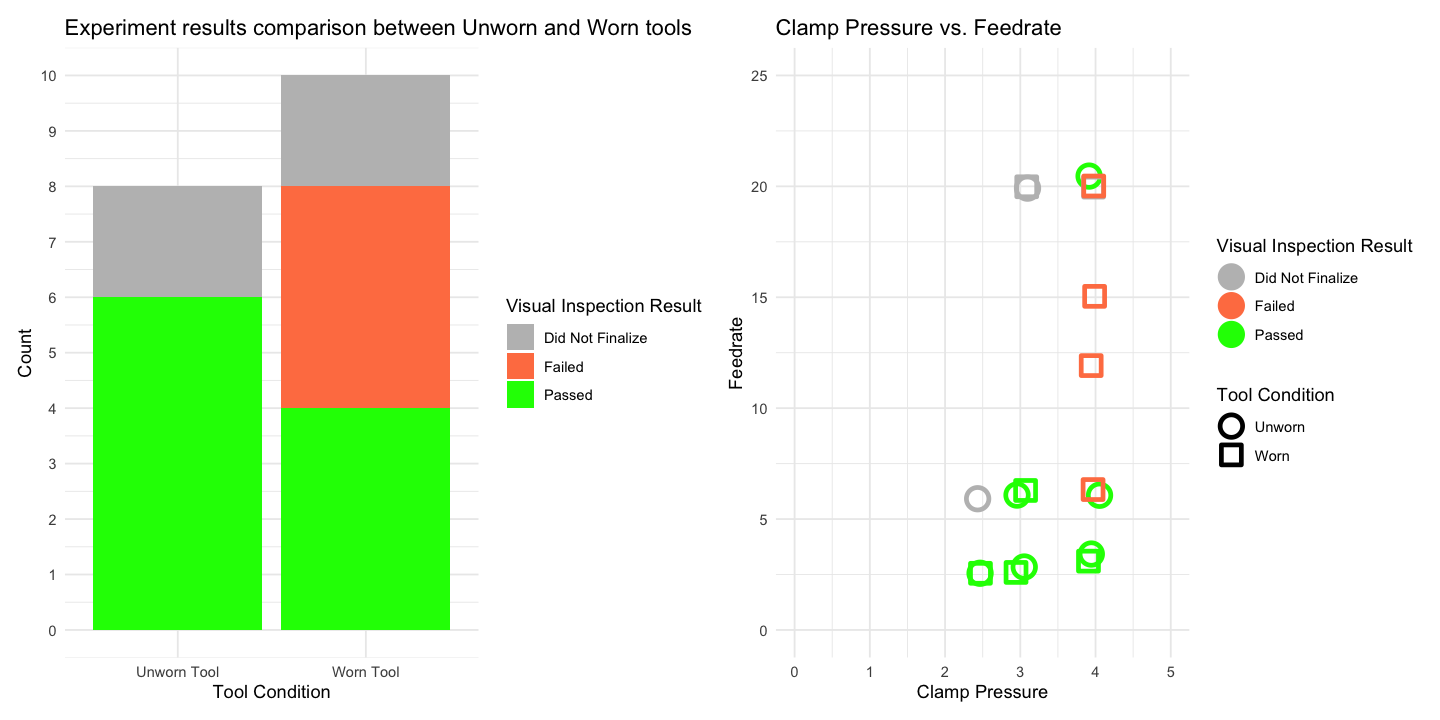

In [244]:
require(patchwork)
options(repr.plot.width = 12, repr.plot.height = 6)  # Sets the width and height in inches

# Create the stacked bar plot
p1 <- ggplot(exp_result, aes(x = tool_condition, fill = passed_visual_inspection)) +
    geom_bar(position = "stack") +
    scale_y_continuous(breaks = seq(0, 10, by = 1)) +
    scale_x_discrete(labels = c("unworn" = "Unworn Tool", "worn" = "Worn Tool")) +
    scale_fill_manual(values = c("dnf" = "grey", "yes" = "green", "no" = "coral"),
        labels = c("dnf" = "Did Not Finalize", "yes" = "Passed", "no" = "Failed")) +
    labs(title = "Experiment results comparison between Unworn and Worn tools",
        x = "Tool Condition",
        y = "Count",
        fill = "Visual Inspection Result") +
    theme_minimal()

# Create the scatter plot
clamp_pressure_range = max(exp_result$clamp_pressure) - min(exp_result$clamp_pressure)
feedrate_range = max(exp_result$feedrate) - min(exp_result$feedrate)
p2 <- ggplot(exp_result, aes(x = clamp_pressure, y = feedrate, color = passed_visual_inspection, shape = tool_condition)) +
  geom_jitter(width = 5/50, height = 25/50, size = 5, alpha=1, stroke = 2) +
      scale_x_continuous(limits = c(0, 5)) +
    scale_y_continuous(limits = c(0, 25)) +
    scale_color_manual(values = c("dnf" = "grey", "yes" = "green", "no" = "coral"), 
        labels = c("dnf" = "Did Not Finalize", "yes" = "Passed", "no" = "Failed")) + 
    scale_shape_manual(values = c("unworn" = 21, "worn" = 22),
        labels = c("unworn" = "Unworn", "worn" = "Worn")) + 
    labs(title = "Clamp Pressure vs. Feedrate",
       x = "Clamp Pressure",
       y = "Feedrate",
       color = "Visual Inspection Result",
       shape = "Tool Condition") +
    theme_minimal()

p1 + p2

One may also be interested in the tool path during the milling process. We can create a subplot for each experiment. Here we show Experiment 1 as an example. Note that the milling process involved "up" and "down" milling: up milling (conventional milling) feeds the workpiece against the cutter's rotation, while down milling (climb milling) feeds the workpiece with the cutter's rotation. In our case, the left side of "S" was up milled and the right hand side was down milled.

The subplots with grey backgrounds are jobs that did not finalize. In experiments 4, 5, and 16, the job stopped during the up milling of Layer 1; in experiment 7, the job stopped during the up milling of Layer 2 (though the trace of Layer 1 Up was already warped). In up milling, the cutting edge of the tool rubs against the workpiece before fully engaging, thus exerting a lifting force and more likely to dislocate the workpiece.

Experiment 1, which had the ideal condition (unworn tool, moderate feedrate, tight clamping), appeared the most consistant.

Warning message in geom_rect(data = first_dnf_instances, aes(xmin = -Inf, xmax = Inf, :
"All aesthetics have length 1, but the data has 4 rows.
i Please consider using `annotate()` or provide this layer with data containing
  a single row."
Warning message in geom_rect(data = first_fail_instances, aes(xmin = -Inf, xmax = Inf, :
"All aesthetics have length 1, but the data has 4 rows.
i Please consider using `annotate()` or provide this layer with data containing
  a single row."


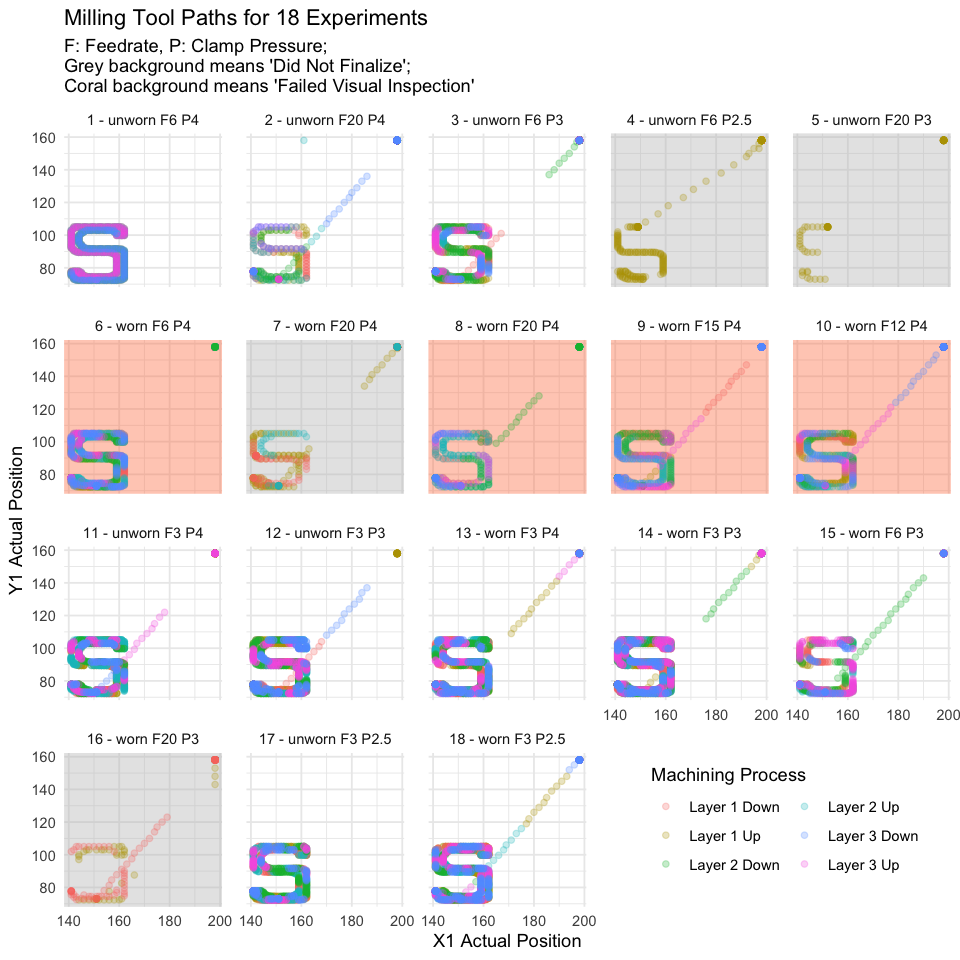

In [245]:
options(repr.plot.width = 8, repr.plot.height = 8)  # Sets the width and height in inches

# Filter the subset based on conditions
subset_df <- df[grepl("Layer", df$Machining_Process) & 
                df$No %in% 1:18, ]  # Ensure it includes experiment IDs 1 to 18 (no really needed)
subset_df$Facet_Title <- paste0(subset_df$No, " - ", 
     subset_df$tool_condition, " F", subset_df$feedrate, " P", subset_df$clamp_pressure)
subset_df$Facet_Title <- factor(subset_df$Facet_Title, 
     levels = unique(subset_df$Facet_Title[order(subset_df$No)])) # Ensure Facet_Title is a factor ordered by No

subset_df_dnf <- subset_df[subset_df$passed_visual_inspection == "dnf", ]  # Get all "dnf"s
first_dnf_instances <- subset_df_dnf[!duplicated(subset_df_dnf$No), ]  # Keep the first occurrence of each experiment
subset_fail_dnf <- subset_df[subset_df$passed_visual_inspection == "no", ]  # Get all failed visual inspections
first_fail_instances <- subset_fail_dnf[!duplicated(subset_fail_dnf$No), ]  # Keep the first occurrence of each experiment



# Create scatter plots with faceting by experiment ID
ggplot(subset_df, aes(x = X1_ActualPosition, y = Y1_ActualPosition, color = Machining_Process)) +
     geom_rect(data = first_dnf_instances, 
          aes(xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf),
          fill = "grey", alpha = 0.4, inherit.aes = FALSE) +
     geom_rect(data = first_fail_instances, 
          aes(xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf),
          fill = "coral", alpha = 0.4, inherit.aes = FALSE) +
     geom_point(alpha = 0.25) +
     facet_wrap(~ Facet_Title) +  # Facet by experiment ID
     labs(title = "Milling Tool Paths for 18 Experiments",
               subtitle = paste0("F: Feedrate, P: Clamp Pressure;\n",
               "Grey background means 'Did Not Finalize';\n",
               "Coral background means 'Failed Visual Inspection'"),
               x = "X1 Actual Position",
               y = "Y1 Actual Position",
               color = "Machining Process") +
     theme_minimal() +
     theme(legend.position = c(0.975, 0.025),            # Bottom-right corner
          legend.justification = c("right", "bottom"),   # Align legend to bottom-right
          panel.spacing = unit(1, "lines")) +            # Increase spacing between subplots
     guides(color = guide_legend(ncol = 2))    # Align the legend within the bottom-right corner

The position of the tool head shows the overall job processes. However, it does not reveal more characteristics of machining with a worn tool. We now create a series of plot showing the velocities X, Y, Z, and S. Using a worn tool seemed to cause more erratic changes in 
X, and Y velocities (the points are more scattered away from the zero).


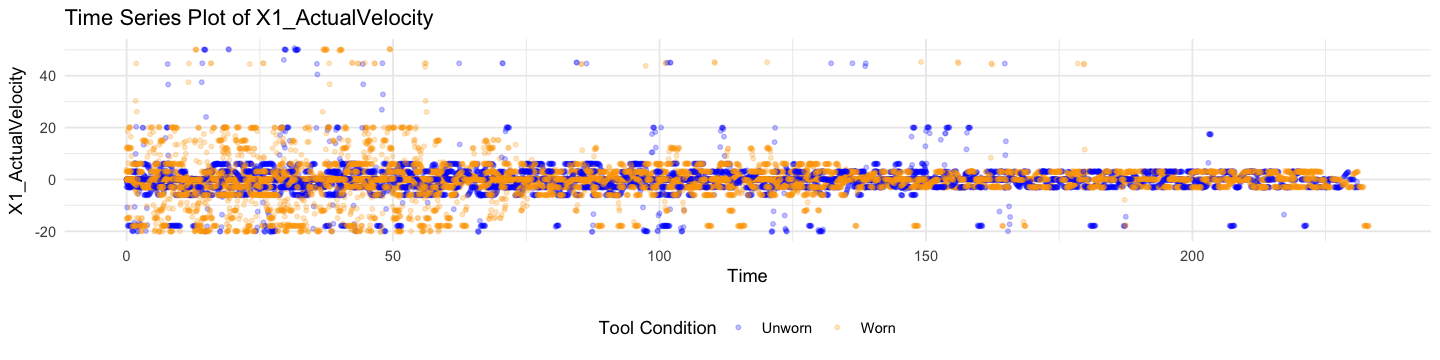

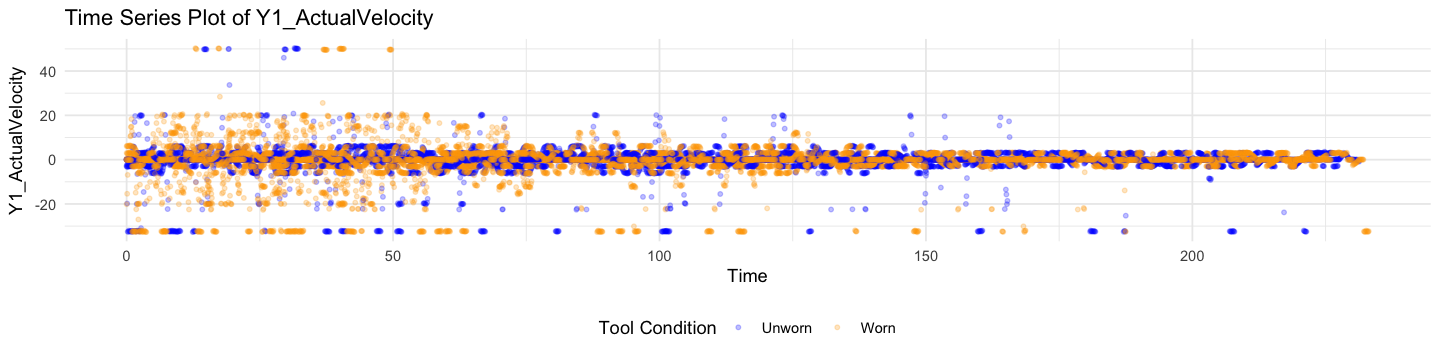

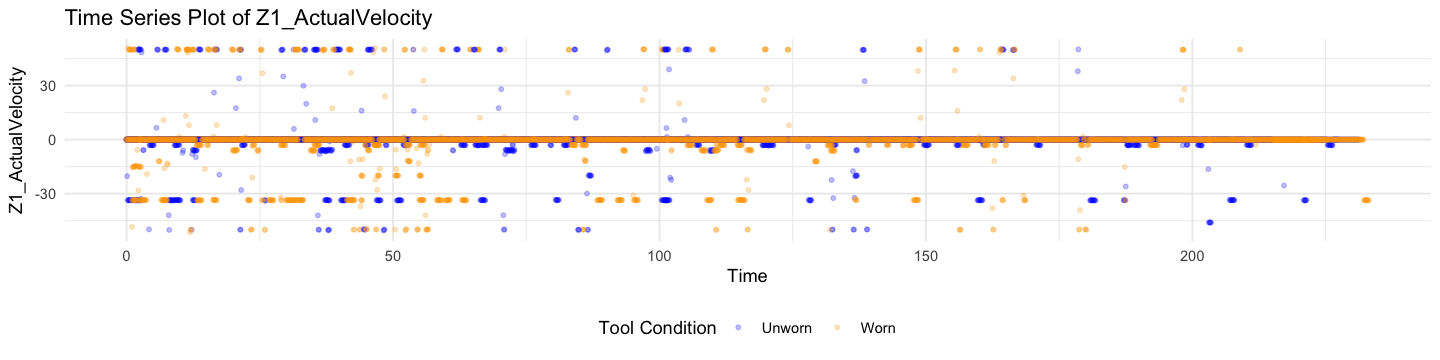

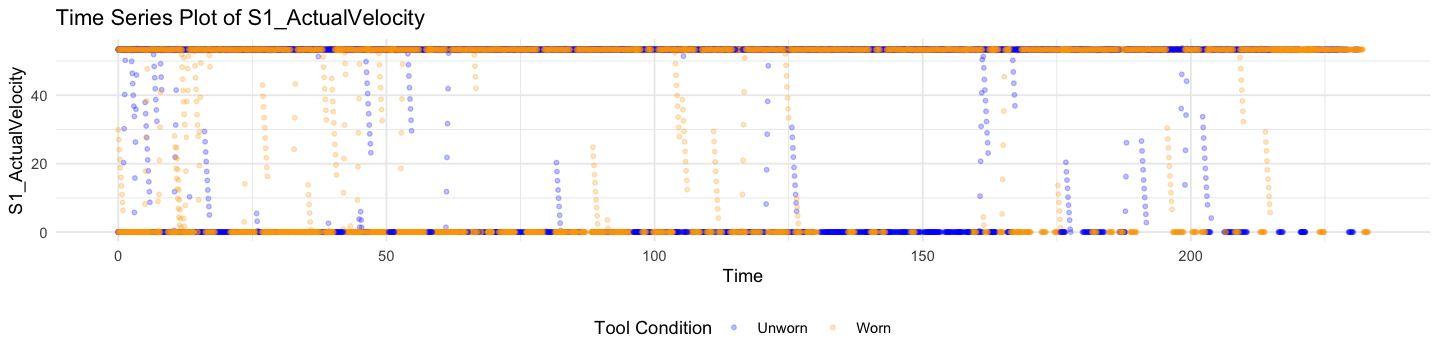

In [246]:
options(repr.plot.width = 12, repr.plot.height = 3)  # Sets the width and height in inches
variables = c('X1_ActualVelocity', "Y1_ActualVelocity", "Z1_ActualVelocity", "S1_ActualVelocity")
for (element in variables) {
    # Create plot
	p <- ggplot(df, aes_string(x = "Time", y = element, color = "tool_condition", group="tool_condition")) +
        geom_point(alpha = 0.25, size = 1) +  # Creates the time series plot with lines
        scale_color_manual(values = c("unworn" = "blue", "worn" = "orange"), 
                labels = c("unworn" = "Unworn", "worn" = "Worn")) + 
        # facet_wrap(~ tool_condition, ncol = 1) +
        labs(
            title = paste0("Time Series Plot of ",element),
            x = "Time",
            y = element,
            color = "Tool Condition"
        ) +
        theme_minimal() +
        theme(
            legend.position = "bottom",  # Move the legend above the plot
            legend.direction = "horizontal",  # Flatten the legend into a horizontal orientation
            legend.box = "horizontal"  # Ensure proper layout for the horizontal legend
        )
    print(p)
}


If we look at the voltages of the X, Y, and spindle motors, we can see more frequent voltage peaks. However, there are two more experiments involving worn tools, so additional analyses are required.

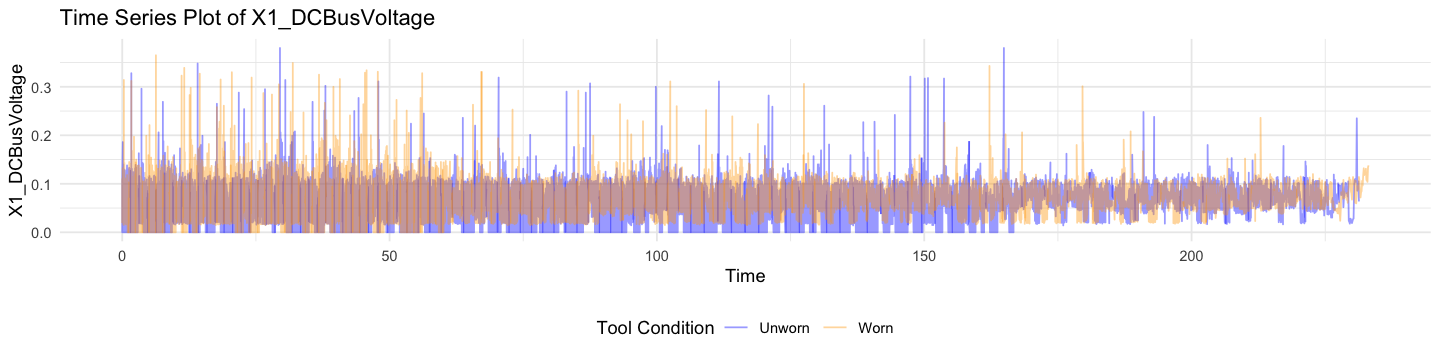

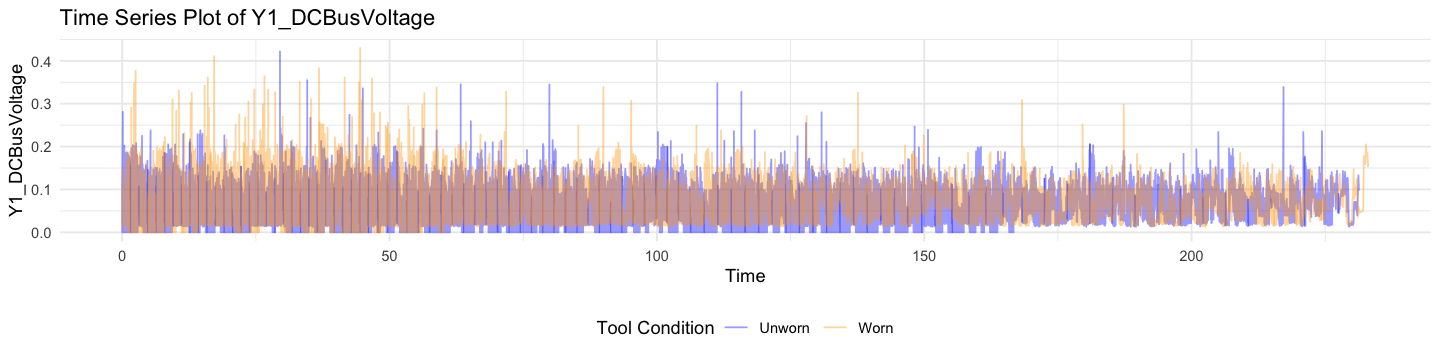

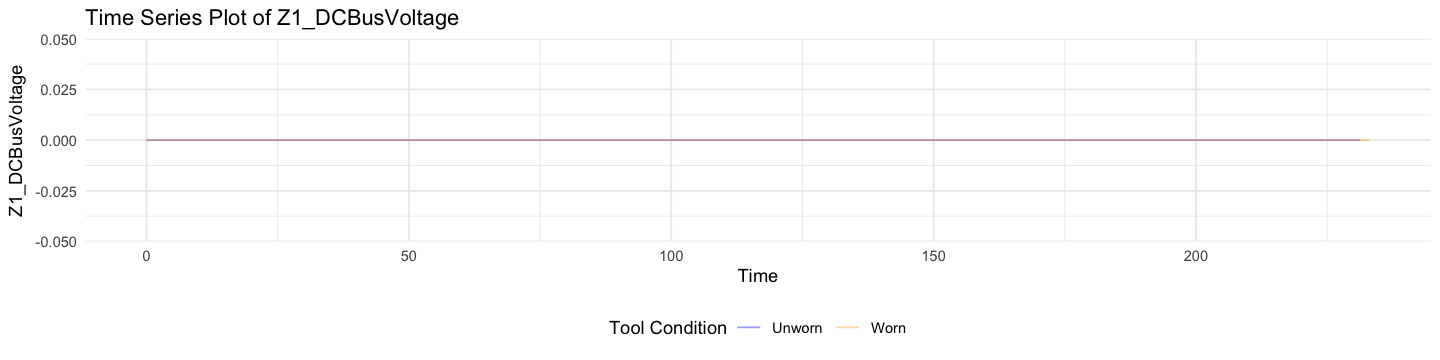

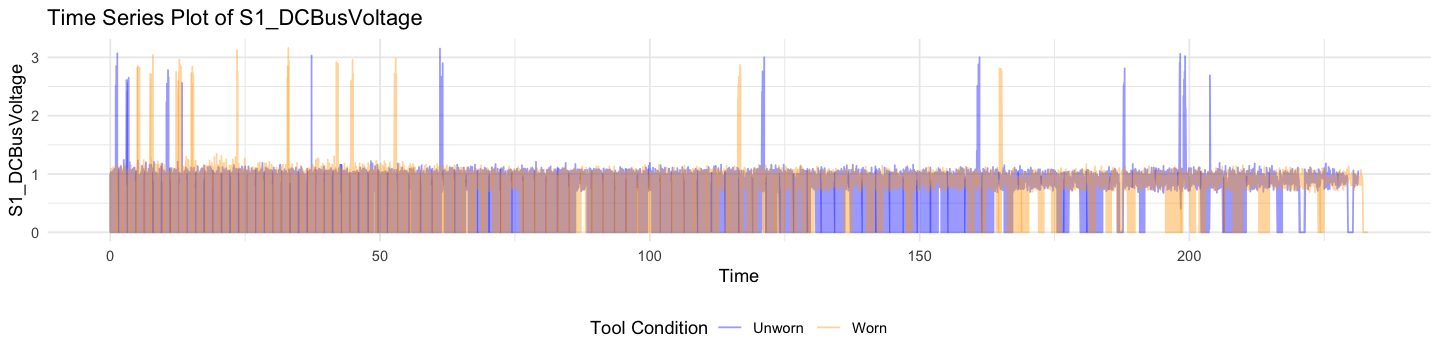

In [247]:
options(repr.plot.width = 12, repr.plot.height = 3)  # Sets the width and height in inches
variables = c('X1_DCBusVoltage', "Y1_DCBusVoltage", "Z1_DCBusVoltage", "S1_DCBusVoltage")
for (element in variables) {
    # Create plot
	p <- ggplot(df, aes_string(x = "Time", y = element, color = "tool_condition", group="tool_condition")) +
        geom_line(alpha = 0.4) +  # Creates the time series plot with lines
        scale_color_manual(values = c("unworn" = "blue", "worn" = "orange"), 
                labels = c("unworn" = "Unworn", "worn" = "Worn")) + 
        # facet_wrap(~ tool_condition, ncol = 1) +
        labs(
            title = paste0("Time Series Plot of ",element),
            x = "Time",
            y = element,
            color = "Tool Condition"
        ) +
        theme_minimal() +
        theme(
            legend.position = "bottom",  # Move the legend above the plot
            legend.direction = "horizontal",  # Flatten the legend into a horizontal orientation
            legend.box = "horizontal"  # Ensure proper layout for the horizontal legend
        )
    print(p)
}


## Data Analysis

Our goal is to model and predict tool wear based on the milling machine behavior. There are at least two ways to approach this:
1. Treat every time series entry as individual, instantaneous observation and use them to train a classifier. If the classifier achieves a decent accuracy, we can confirm our hypothesis and then make the machine count the instances where the tool is flagged as worn. If the count of "worn" flags exceeds a threshold, the tool can be classified as 'worn' with confidence.
2. Consider the time series in the frequency domain. It is possible that a worn tool can produce "erratic" movements. For every layer we can use Fast Fourier Transform (FFT) to obtain the frequency of the highest amplitudes. we may be able to fit a regression model to predict the tool condition as well.

<div class='alert'>

### Note on the Frequency Domain method

Half way through the development, I realized that the sampling rate of 10 Hz (100 ms every data point) is insufficient for the frequency domain analysis, since the highest valid frequency we can capture is merely 5 Hz (see [Nyquist Frequency](https://en.wikipedia.org/wiki/Nyquist_frequency)). In our case, we explore Method 2 as a _toy example_.

</div>

### Modeling with Time Series Entries

Below is a quick test of equal variances (homoscedasticity) between the two groups -- `unworn` and `worn`. We can see that the Levene tests show that several variables do not have equal variances between groups. Thus, we may not use certain classification methods such as Linear Discriminant Analysis (LDA) or Ordinary Least-Squares (OLS) regression.

In [248]:
# Load the car package (if not already installed)
library(car)

# Loop through the columns and perform Levene's test
levene_results <- list()
variables = c('X1_ActualVelocity', "Y1_ActualVelocity", "S1_ActualVelocity",
    'X1_DCBusVoltage', "Y1_DCBusVoltage", "S1_DCBusVoltage",
    'X1_CurrentFeedback', 'Y1_CurrentFeedback', 'S1_CurrentFeedback')
for (col in variables) {
    formula <- as.formula(paste(col, "~ tool_condition"))
    levene_results[[col]] <- leveneTest(formula, data = df)
}

# Print results
levene_results

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,127.9661,1.345059e-29
,25284,NA,NA
,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,68.84394,1.118262e-16
,25284,NA,NA
,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,11.94485,0.000548885


We can see that our dataset has fairly balanced classes, so no resampling is used in this case.

Here we choose Generalized Linear Model (GLM) and Decision Tree as examples. We apply a 10-fold cross-validation in our training and evaluate the model performance using an unseen test set.

We utilize the `caret` package for cross-validation. The package can automatically search for a good set of parameters through cross-validation. (The `boot` package does not seem to be as versatile.)

In [28]:
table(df$tool_condition)

library(caret)

set.seed(1) # Reproducibility
n <- nrow(df)
train_indices <- sample(1:n, size = floor(0.8 * n))  # 80% for training

# Split the data
train_data <- df[train_indices, ]
test_data <- df[-train_indices, ]

# Define cross-validation method
control <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation


# Define formula
excluded_vars <- names(exp_result)   # basically data from the general experiment results
formula <- as.formula(
  paste("tool_condition ~", paste(setdiff(names(df), excluded_vars), collapse = " + "))
)




unworn   worn 
 11978  13308 

In [44]:


# Train GLM (logistic regression) model with cross-validation
glm_model <- train(
  formula,  # Formula
  data = train_data,             # Training data
  method = "glm",                # Generalized Linear Model
  family = binomial,             # Binomial family for logistic regression
  trControl = control            # Cross-validation settings
)

# # View cross-validation results
print(glm_model)

# Predict on the test set
glm_pred_prob <- predict(glm_model, test_data, type = "prob")  # Predicted probabilities
glm_pred <- predict(glm_model, test_data)               # Class predictions

# Evaluate model performance on the test set
accuracy <- mean(glm_pred == test_data$tool_condition)
cat("Accuracy on test set:", accuracy, "\n")

# Confusion matrix
confusionMatrix(glm_pred, test_data$tool_condition)





Generalized Linear Model 

20228 samples
   49 predictor
    2 classes: 'unworn', 'worn' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 18205, 18205, 18206, 18205, 18205, 18205, ... 
Resampling results:

  Accuracy   Kappa   
  0.5936317  0.180697

Accuracy on test set: 0.5980625 


Confusion Matrix and Statistics

          Reference
Prediction unworn worn
    unworn   1245  881
    worn     1152 1780
                                          
               Accuracy : 0.5981          
                 95% CI : (0.5844, 0.6116)
    No Information Rate : 0.5261          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.1894          
                                          
 Mcnemar's Test P-Value : 2.122e-09       
                                          
            Sensitivity : 0.5194          
            Specificity : 0.6689          
         Pos Pred Value : 0.5856          
         Neg Pred Value : 0.6071          
             Prevalence : 0.4739          
         Detection Rate : 0.2461          
   Detection Prevalence : 0.4203          
      Balanced Accuracy : 0.5942          
                                          
       'Positive' Class : unworn          
                  

CART 

25286 samples
   49 predictor
    2 classes: 'unworn', 'worn' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 22759, 22757, 22757, 22757, 22757, 22757, ... 
Resampling results across tuning parameters:

  cp          Accuracy   Kappa    
  0.09642678  0.8637552  0.7227689
  0.10957589  0.7802834  0.5466526
  0.21990316  0.5759708  0.1091695

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.09642678.
Decision Tree Accuracy on Test Set: 0.8440095 


Confusion Matrix and Statistics

          Reference
Prediction unworn worn
    unworn   1614    6
    worn      783 2655
                                          
               Accuracy : 0.844           
                 95% CI : (0.8337, 0.8539)
    No Information Rate : 0.5261          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6821          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.6733          
            Specificity : 0.9977          
         Pos Pred Value : 0.9963          
         Neg Pred Value : 0.7723          
             Prevalence : 0.4739          
         Detection Rate : 0.3191          
   Detection Prevalence : 0.3203          
      Balanced Accuracy : 0.8355          
                                          
       'Positive' Class : unworn          
                  

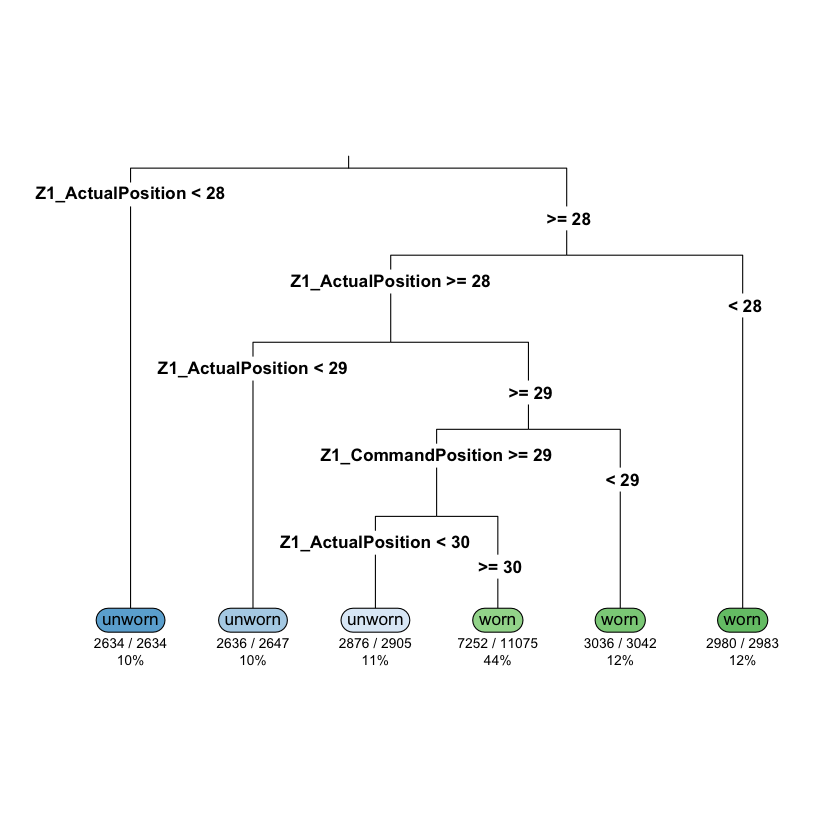

In [45]:
library(rpart)
library(rpart.plot) # For plotting

# Train Decision Tree model
# Similar caret settings are used
tree_model <- train(
  formula,
  data = df,
  method = "rpart",
  trControl = control
)

print(tree_model)
# Visualize the decision tree
rpart.plot(tree_model$finalModel, type = 3, extra = 102, under = TRUE)

# Predict on the test set
tree_pred <- predict(tree_model, test_data)

# Evaluate accuracy
tree_accuracy <- mean(tree_pred == test_data$tool_condition)
cat("Decision Tree Accuracy on Test Set:", tree_accuracy, "\n")

confusionMatrix(tree_pred, test_data$tool_condition)

It appears that the Decision Tree significantly outperformed GLM. However, once we plot out the tree model, we can see that the tree heavily relied on the discrepancy between the command Z-position and the actual Z-position -- which makes sense but is also very trivial. We can assume that the study was conducted on the same type of standardized tool (or even the same tool), and a worn tool should result in the variation of the vertical positioning. Should we swap in another worn tool, relying on the Z-position may not be as affective. 

Now, if we remove the `Z1_ActualPosition` and `Z1_CommandPosition` from the formula, the performance suffers.

Warning message in cbind(names(exp_result), c("Z1_ActualPosition", "Z1_CommandPosition")):
"number of rows of result is not a multiple of vector length (arg 2)"


Decision Tree Accuracy on Test Set: 0.6623171 


Confusion Matrix and Statistics

          Reference
Prediction unworn worn
    unworn   2191 1502
    worn      206 1159
                                          
               Accuracy : 0.6623          
                 95% CI : (0.6491, 0.6754)
    No Information Rate : 0.5261          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3405          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9141          
            Specificity : 0.4356          
         Pos Pred Value : 0.5933          
         Neg Pred Value : 0.8491          
             Prevalence : 0.4739          
         Detection Rate : 0.4332          
   Detection Prevalence : 0.7301          
      Balanced Accuracy : 0.6748          
                                          
       'Positive' Class : unworn          
                  

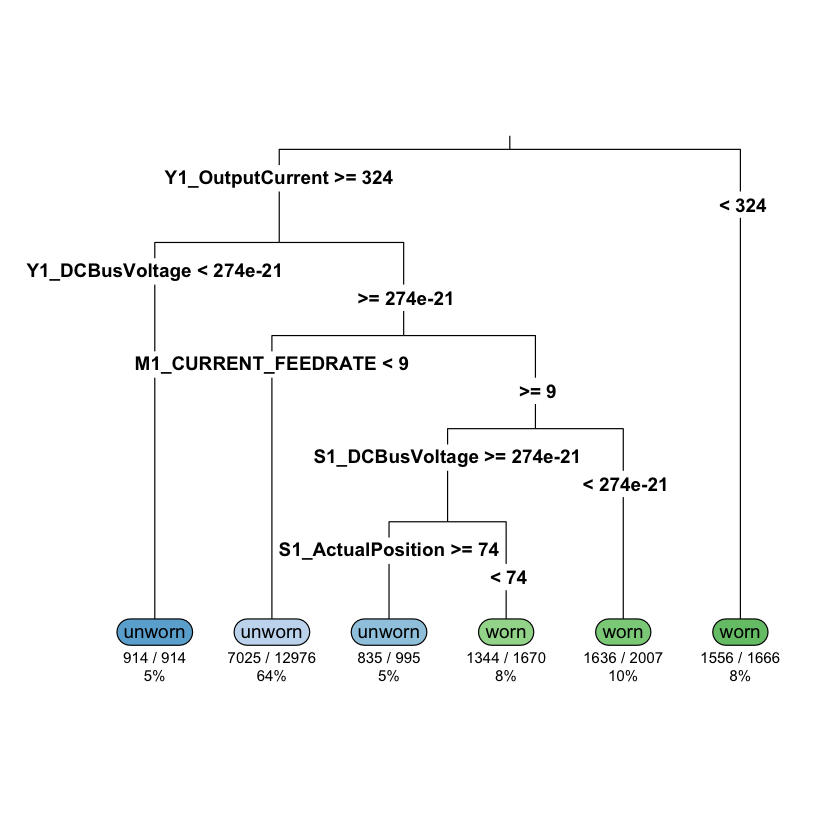

In [46]:
# Define formula
excluded_vars <- cbind(names(exp_result), c('Z1_ActualPosition', 'Z1_CommandPosition'))   # basically data from the general experiment results
formula_no_Z <- as.formula(
  paste("tool_condition ~", paste(setdiff(names(df), excluded_vars), collapse = " + "))
)

# Train Decision Tree model
# Similar caret settings are used
tree_model <- train(
  formula_no_Z,
  data = train_data,
  method = "rpart",
  trControl = control
)

# Visualize the decision tree
rpart.plot(tree_model$finalModel, type = 3, extra = 102, under = TRUE)

# Predict on the test set
tree_pred <- predict(tree_model, test_data)

# Evaluate accuracy
tree_accuracy <- mean(tree_pred == test_data$tool_condition)
cat("Decision Tree Accuracy on Test Set:", tree_accuracy, "\n")

confusionMatrix(tree_pred, test_data$tool_condition)

Finally, for this instantaneous-sampling approach, we test out the [LightGBM](https://dl.acm.org/doi/10.5555/3294996.3295074) algorithm, as the above basic algorithms are deemed insufficient. 

Our trained model achieved an accuracy of 92.86%, which is quite impressive. It identified generalizable features such as spindle voltage and current as well as the motor currents in X- and Y-directions. **This, to some extent, confirms our hypothesis.** 

Still, we have to acknowledge that:
1. We may need additional samples involving other types of tools and materials to confirm that our results are generalizable. 
2. There was also information leak from training samples obtained in the same experiments as the test samples. Due to the scope of this project, we did not apply the Leave-One-Group-Out Cross-Validation (LOGOCV). Future work may incorporate this technique for more robust modeling.

[LightGBM] [Info] Number of positive: 10647, number of negative: 9581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7013
[LightGBM] [Info] Number of data points in the train set: 20228, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526350 -> initscore=0.105496
[LightGBM] [Info] Start training from score 0.105496
[1]:  test's binary_error:0.267695 
Will train until there is no improvement in 10 rounds.
[2]:  test's binary_error:0.223804 
[3]:  test's binary_error:0.208185 
[4]:  test's binary_error:0.202254 
[5]:  test's binary_error:0.188612 
[6]:  test's binary_error:0.188217 
[7]:  test's binary_error:0.180506 
[8]:  test's binary_error:0.176157 
[9]:  test's binary_error:0.175761 
[10]:  test's binary_error:0.17497 
[11]:  test's binary_error:0.1

         Actual
Predicted    0    1
        0 2222  186
        1  175 2475

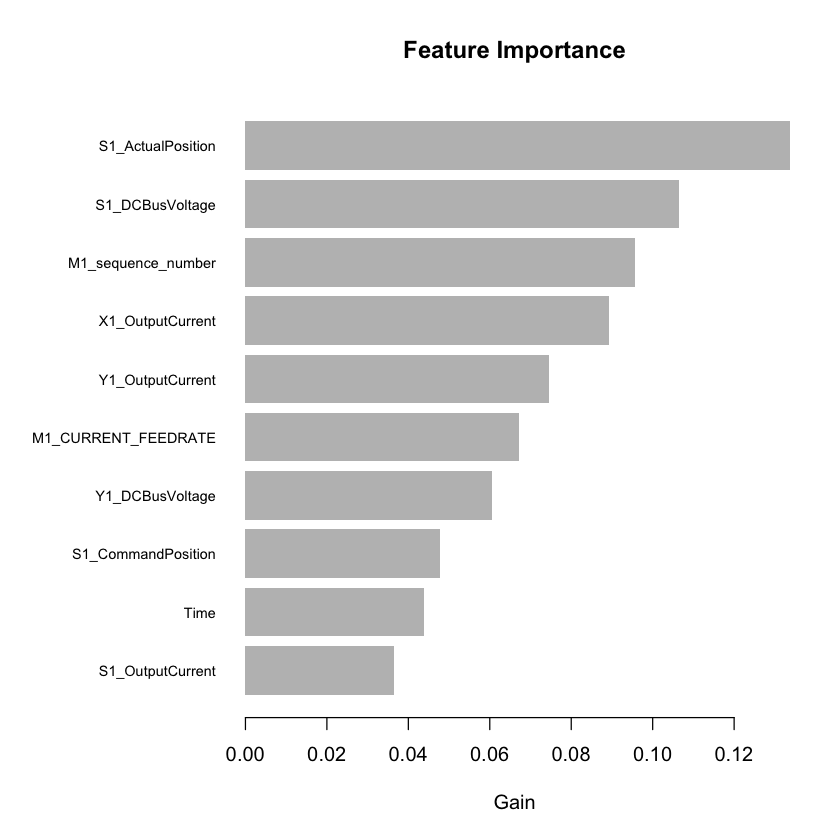

In [47]:

library(lightgbm)

# Make y into numeric
y_df <- df$tool_condition  |> 
    factor(levels = c("unworn", "worn")) |>
    as.numeric() - 1

x_df <- df[, setdiff(names(df), excluded_vars)]
x_df$Machining_Process <- as.numeric(x_df$Machining_Process) # for categorical feature


# Split the data
x_train <- as.matrix(x_df[train_indices, ])
x_test <- as.matrix(x_df[-train_indices, ])

y_train <- y_df[train_indices ]
y_test <- y_df[-train_indices] 

# Create LightGBM dataset
train_lgb <- lgb.Dataset(data = x_train, label = y_train) 


# Define parameters
params <- list(
  objective = "binary",  # Binary classification
  metric = "binary_error",  # Error rate
  boosting = "gbdt",  # Gradient Boosting Decision Tree
  learning_rate = 0.1,
  num_leaves = 31,
  max_depth = -1,
  feature_fraction = 0.8
)

# Train the model
lgb_model <- lgb.train(
  params = params,
  data = train_lgb,
  nrounds = 100,  # Number of boosting iterations
  valids = list(test = lgb.Dataset(data = x_test, label = y_test)),
  early_stopping_rounds = 10
)

# Plot feature importance
importance <- lgb.importance(lgb_model)
lgb.plot.importance(importance, measure = "Gain")

# Predict on the test set
lgb_prob <- predict(lgb_model, x_test)
lgb_pred <- ifelse(lgb_prob > 0.5, 1, 0)

# Calculate accuracy
accuracy <- mean(lgb_pred == y_test)
cat("Accuracy on test set:", accuracy, "\n")

# Confusion matrix
table(Predicted = lgb_pred, Actual = y_test)

### Modeling with Freqency Data (Toy Example)

As discussed above, the extra variation in the tool movement may be reflected on the frequency domain. We can extract a few frequency features using Fast Fourier Transform (FFT). The transformed data shows us the magnitude of vibration or value changes at certain certain frequencies.

Unfortunately, our dataset does not have a high enough sampling rate to provide information of higher-frequency vibrations and power changes. The exploration below should be regarded as a toy example.

We assume a sufficiently high sampling rate here so the frequency spectrum can cover up to 250 Hz. Inspired by the LightGBM feature importances above, we select the `OutputCurrent` features of the X and Y motors and the spindle motor.


,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,...,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,Time,Group
,<int>,<fct>,<int>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<chr>
32,1,wax,6,4,unworn,yes,yes,151,0.075,37.50,...,318,44.9,0.1500,12,1,12,6,Layer 1 Up,3.1,Exp 1 Layer 1 Up
33,1,wax,6,4,unworn,yes,yes,151,-0.075,-37.50,...,317,72.8,0.2310,12,1,14,6,Layer 1 Up,3.2,Exp 1 Layer 1 Up
34,1,wax,6,4,unworn,yes,yes,151,-6.000,6.25,...,309,88.4,0.3410,12,1,14,6,Layer 1 Up,3.3,Exp 1 Layer 1 Up
35,1,wax,6,4,unworn,yes,yes,150,-6.150,-43.80,...,306,109.0,0.4410,12,1,14,6,Layer 1 Up,3.4,Exp 1 Layer 1 Up
36,1,wax,6,4,unworn,yes,yes,149,-5.930,62.50,...,324,112.0,0.0746,12,1,14,6,Layer 1 Up,3.5,Exp 1 Layer 1 Up
37,1,wax,6,4,unworn,yes,yes,149,-5.930,-12.50,...,320,117.0,0.2310,12,1,14,6,Layer 1 Up,3.6,Exp 1 Layer 1 Up



unworn   worn 
    38     53 

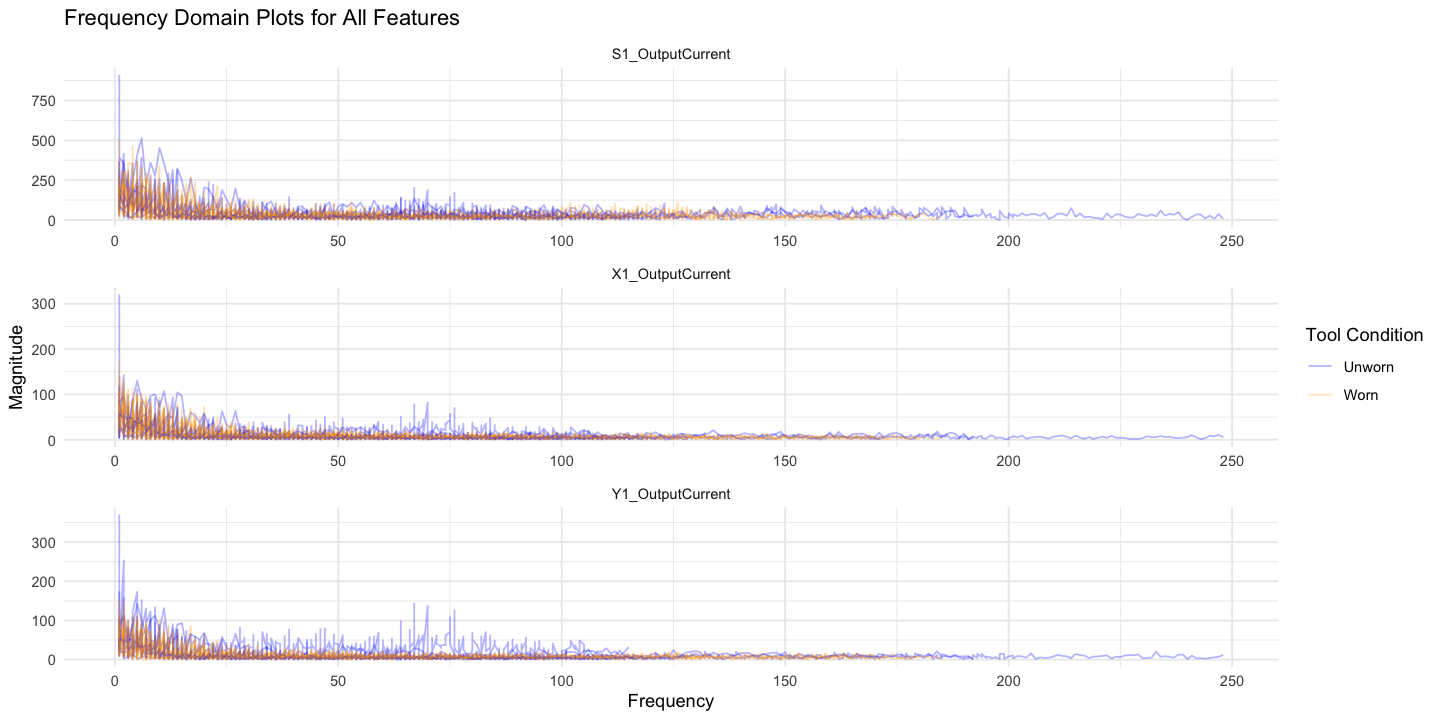

In [142]:
# Extract Layer data and group them by experiment, layer, and milling type
layer_df <- df[grepl("Layer", df$Machining_Process) & # Extract data in each layer
                df$No %in% 1:18, ]  # Ensure it includes experiment IDs 1 to 18 (no really needed)
layer_df$Group <- paste('Exp', layer_df$No, layer_df$Machining_Process, sep = ' ')
head(layer_df)


# Array of column names to process
features <- c("X1_OutputCurrent", "Y1_OutputCurrent", "S1_OutputCurrent")

# Initialize an empty dataframe to store the results
freq_df <- data.frame(Group = integer())

# Store frequency domain data for plotting
frequency_data <- list()

# Function to calculate the (2nd) highest frequency for a given feature
extract_frequency_features <- function(data_in) {
    # Perform FFT
    fft_result <- fft(data_in)
    
    # Calculate frequency and magnitudes
    magnitudes <- Mod(fft_result)[2:(length(data_in)/2)]    # removing the DC component
    frequencies <- seq(1, length(magnitudes))
    
    # Compute peak-to-average ratio
    peak_to_average_ratio <- max(magnitudes) / mean(magnitudes)
    
    # Compute frequency spread (weighted variance)
    weighted_variance <- sum((frequencies - mean(frequencies))^2 * magnitudes) / sum(magnitudes)

    # Return both the highest frequency value and its magnitude
    return(
        list(Peak2Avg = peak_to_average_ratio, 
            Spread = weighted_variance,
            magnitudes = magnitudes)
    )
}


# Iterate over each group
for (group in unique(layer_df$Group)) {
    # Subset the dataframe for the current group
    group_data <- layer_df[layer_df$Group == group, ]
    
    # Initialize a row for the current group
    group_row <- data.frame(group = group, 
        tool_condition = group_data$tool_condition[1],
        No = group_data$No[1])

    # Extract highest frequency and magnitude for each feature
    for (feature in features) {
        freq_info <- extract_frequency_features(group_data[[feature]])
        group_row[[paste0(feature, "_Peak2Avg")]] <- freq_info$Peak2Avg
        group_row[[paste0(feature, "_Spread")]] <- freq_info$Spread

         # Save frequency domain data for plotting
        frequency_data[[paste0(group, "_", feature)]] <- data.frame(
            Frequency = seq(1, length(freq_info$magnitudes)),
            Magnitude = freq_info$magnitudes,
            No = group_row$No,
            tool_condition = group_row$tool_condition,
            Feature = feature
        )
    }


    # Append results to the result dataframe
    freq_df <- rbind(freq_df, group_row)

}

# View the resulting dataframe
table(freq_df$tool_condition)

# Combine frequency data into one dataframe for plotting
plot_data <- do.call(rbind, frequency_data)

# Combine frequency data into one dataframe for plotting
plot_data <- do.call(rbind, frequency_data)

# Create subplots for each feature
options(repr.plot.width = 12, repr.plot.height = 6)  # Sets the width and height in inches
ggplot(plot_data, aes(x = Frequency, y = Magnitude, group = No, color = tool_condition)) +
  geom_line(alpha = 0.3) +
  facet_wrap(~ Feature, scales = "free", ncol = 1) +
  theme_minimal() +
  scale_color_manual(values = c("unworn" = "blue", "worn" = "orange"), 
                labels = c("unworn" = "Unworn", "worn" = "Worn")) + 
  labs(title = "Frequency Domain Plots for All Features",
       x = "Frequency",
       y = "Magnitude",
       color = "Tool Condition")


We can then attempt to fit a logistic regression model on it and test the robustness of prediction using bootstrap.

In [143]:
# Get column names except the response and exclude variables
predictors <- setdiff(names(freq_df), c('group', 'tool_condition', 'No'))
# Dynamically create the formula
freq_formula <- as.formula(paste('tool_condition', "~", paste(predictors, collapse = " + ")))

glm.fit = glm(freq_formula, 
	data=freq_df, family=binomial)

summary(glm.fit)


Call:
glm(formula = freq_formula, family = binomial, data = freq_df)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)  
(Intercept)               -0.232822   0.808936  -0.288   0.7735  
X1_OutputCurrent_Peak2Avg  0.481144   0.295615   1.628   0.1036  
X1_OutputCurrent_Spread    0.009846   0.003848   2.559   0.0105 *
Y1_OutputCurrent_Peak2Avg -0.458559   0.307588  -1.491   0.1360  
Y1_OutputCurrent_Spread   -0.012408   0.005134  -2.417   0.0157 *
S1_OutputCurrent_Peak2Avg  0.218237   0.279788   0.780   0.4354  
S1_OutputCurrent_Spread    0.001794   0.003493   0.514   0.6076  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 123.669  on 90  degrees of freedom
Residual deviance:  98.807  on 84  degrees of freedom
AIC: 112.81

Number of Fisher Scoring iterations: 4


[1] 0.2637363
BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_obj, type = "perc")

Intervals : 
Level     Percentile     
95%   ( 0.1429,  0.3407 )  
Calculations and Intervals on Original Scale


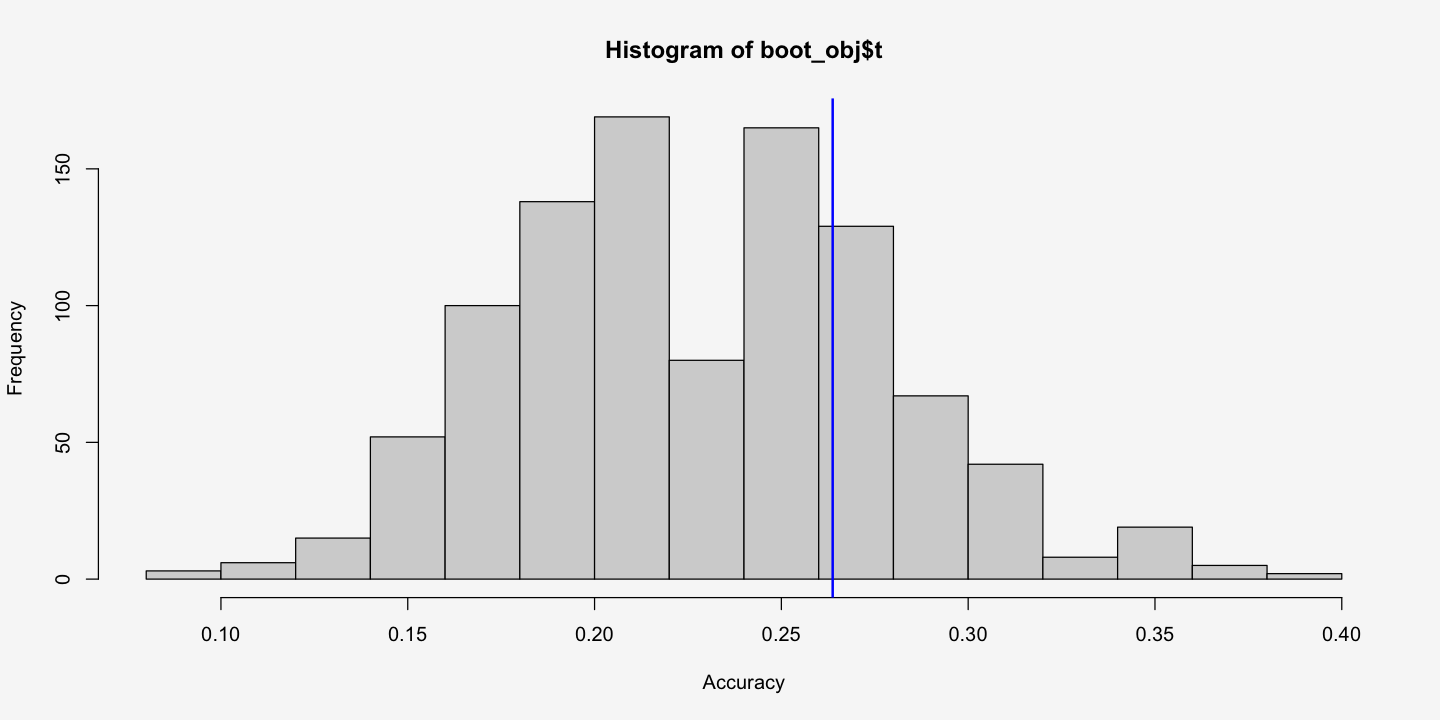

In [144]:
library(boot)
set.seed(1)


# The function needs two inputs: Data, Index
boot.fn <- function(d1, index){  
    d1_s <- d1[index,] # a subset of d1
    boot_fit = glm(freq_formula, 
	    data=d1_s, family=binomial)
    boot_prob = data.frame(predict(boot_fit, type = "response"))
    boot_classes <- factor(ifelse(boot_prob > 0.5, "unworn", "worn"))
    actual_classes <- d1_s$tool_condition
    boot_accuracy <- mean(boot_classes == actual_classes)
    return(boot_accuracy)
}


# Check if the function is defined correctly
orig_accuracy = boot.fn(freq_df, 1:nrow(freq_df))
print(orig_accuracy)


# Run bootstrap
boot_obj = boot(freq_df, boot.fn ,R=1000) #R=repetitions 

# Plot the bootstrap accuracy results
par(bg = "#f7f7f7") # Force background color
hist(boot_obj$t, xlab="Accuracy")
abline(v = orig_accuracy, col = "blue", lwd = 2)

# Show the conficence interval (95%)
print(boot.ci(boot_obj, type = "perc"))

Unfortunately, the features we selected had very limited predictive power, albeit quite consistent based on the bootstrap output. This is understandable given the insufficient sampling rate. Should we have more detailed data, we may be able to run a proper frequency analysis for our modeling and prediction.

## Conclusion

In this project, I explored the possibility of using a CNC milling machine's mechanical and electrical data to predict the wear condition of the milling tool. I was able to visualize the dataset in different ways and train a LightGBM model to achieve decent performance (92% accuracy). However, whether such approach is generalizable has yet to be verified, as the dataset only contains outputs from one machine completing the same job.

I also attempted to transform the machine outputs into frequency data, hoping to analyze potential vibration features. Unfortunately, the sampling rate was not sufficient to produce useful results. We may treat this attempt as a toy example.

In this project I utilized multiple techniques discussed in class including (but not limited to):
1. Data cleansing,
2. Visualization options,
3. Logistic regression,
4. Classification models, and
5. Bootstrapping.
